<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-2969573663.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  return (
/tmp/ipython-input-1-2969573663.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return (


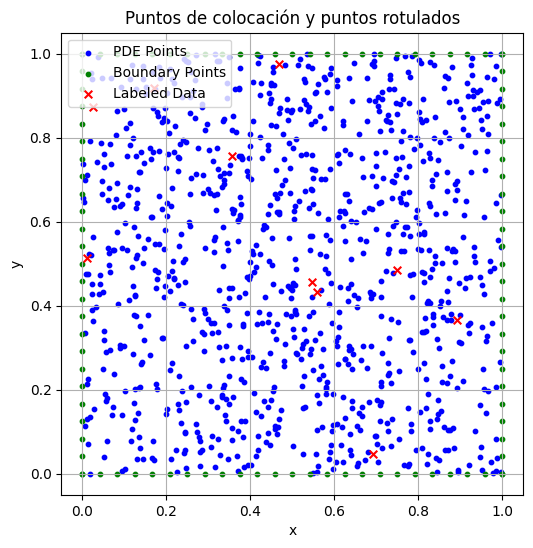

In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']           # presión
u = data_velocity['u']           # componente x
v = data_velocity['v']           # componente y

# Extraer tamaño de malla
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# --- 1. Generar puntos de colocación ---
Npde = 1000
Nbc = 100

# PDE: puntos aleatorios en el interior
x_pde = np.random.uniform(0.0, 1.0, Npde)
y_pde = np.random.uniform(0.0, 1.0, Npde)

# BC: muestreo en bordes
Nbc_per_edge = Nbc // 4
x_bc_top = np.linspace(0, 1, Nbc_per_edge)
y_bc_top = np.ones_like(x_bc_top)

x_bc_bottom = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom = np.zeros_like(x_bc_bottom)

y_bc_left = np.linspace(0, 1, Nbc_per_edge)
x_bc_left = np.zeros_like(y_bc_left)

y_bc_right = np.linspace(0, 1, Nbc_per_edge)
x_bc_right = np.ones_like(y_bc_right)

x_bc = np.concatenate([x_bc_top, x_bc_bottom, x_bc_left, x_bc_right])
y_bc = np.concatenate([y_bc_top, y_bc_bottom, y_bc_left, y_bc_right])

# --- 2. Seleccionar puntos con datos reales (rotulados) ---
Ndata = 10
x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]

    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]

    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / ((x1 - x0) * (y1 - y0))

# Interpolar
p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

plt.figure(figsize=(6, 6))
plt.scatter(x_pde, y_pde, s=10, c='blue', label='PDE Points')
plt.scatter(x_bc, y_bc, s=10, c='green', label='Boundary Points')
plt.scatter(x_data, y_data, s=30, c='red', marker='x', label='Labeled Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos de colocación y puntos rotulados')
plt.grid(True)
plt.axis('square')
plt.show()


Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.